In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle

from itertools import combinations
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsRegressor

import warnings
warnings.filterwarnings('ignore')

In [2]:
dataset = pd.read_csv(r'C:/Users/mathe/Desktop/MATHEUS/UFBA/IC/shalegas-rad/dataset_no_blind.csv', index_col=0)
blind_test = pd.read_csv(r'C:/Users/mathe/Desktop/MATHEUS/UFBA/IC/shalegas-rad/blind_data.csv')

In [3]:
dataset.drop(['Unnamed: 0.1'], axis=1, inplace=True)
blind_test.drop(['Unnamed: 0'], axis=1, inplace=True)

In [4]:
dataset.reset_index(drop=True, inplace=True)

In [5]:
#Acessando o objeto salvo com as 4 layers contendo os indices para acessar no dataset e treinar o algoritmo
with open("kfolds_list","rb") as f:
    k_folds_index= pickle.load(f)

In [6]:
def comb_nation(logs):
    comb = []
    for n in range(len(logs),1,-1):
        for subset in combinations(logs,n):
            comb.append(subset)
    return comb    

In [7]:
def cross_v(variaveis, seed=42):
        X_train, X_test, y_train, y_test = train_test_split(dataset[variaveis],
                                           dataset.DT, test_size= 0.3, random_state = seed)
        scaler = StandardScaler()
        scaler.fit(X_train)
        X_scale = scaler.transform(X_train)
        return X_scale, X_test, y_train, y_test, scaler

In [8]:
comb = comb_nation(['GR','DT','ILD_log10','NPHI'])
mse_test = np.zeros(shape=(200,len(comb)))
mse_train = np.zeros(shape=(200,len(comb)))

for i in range(len(comb)):
    X_scale, X_test, y_train, y_test, scaler = cross_v(list(comb[i]))
# X_scale, X_test, y_train, y_test, scaler = cross_v(['GR','ILD_log10'])    
    for k in range(1,200):
        knn = KNeighborsRegressor(n_neighbors=k)
        knn.fit(X_scale,y_train)
        mse_test[k][i] = mean_squared_error(y_test,knn.predict(scaler.transform(X_test)))
        mse_train[k][i] = mean_squared_error(y_train,knn.predict(X_scale))  

In [9]:
results_train = pd.DataFrame(mse_train, columns=['1','2','3','4','5','6','7','8','9','10','11'])
results_test = pd.DataFrame(mse_test, columns=['1','2','3','4','5','6','7','8','9','10','11'])

Legenda:

1. GR-DT-ILD_log10-NPHI
2. GR-DT-ILD_log10
3. GR-DT-NPHI
4. GR-ILD_log10-NPHI
5. DT-ILD_log10-NPHI
6. GR-DT
7. GR-ILD_log10
8. GR-NPHI
9. DT-ILD_log10
10. DT-NPHI
11. ILD_log10-NPHI

In [10]:
results_train.drop([0],axis=0, inplace=True)
results_train.reset_index(inplace=True)
results_test.drop([0],axis=0, inplace=True)
results_test.reset_index(inplace=True)

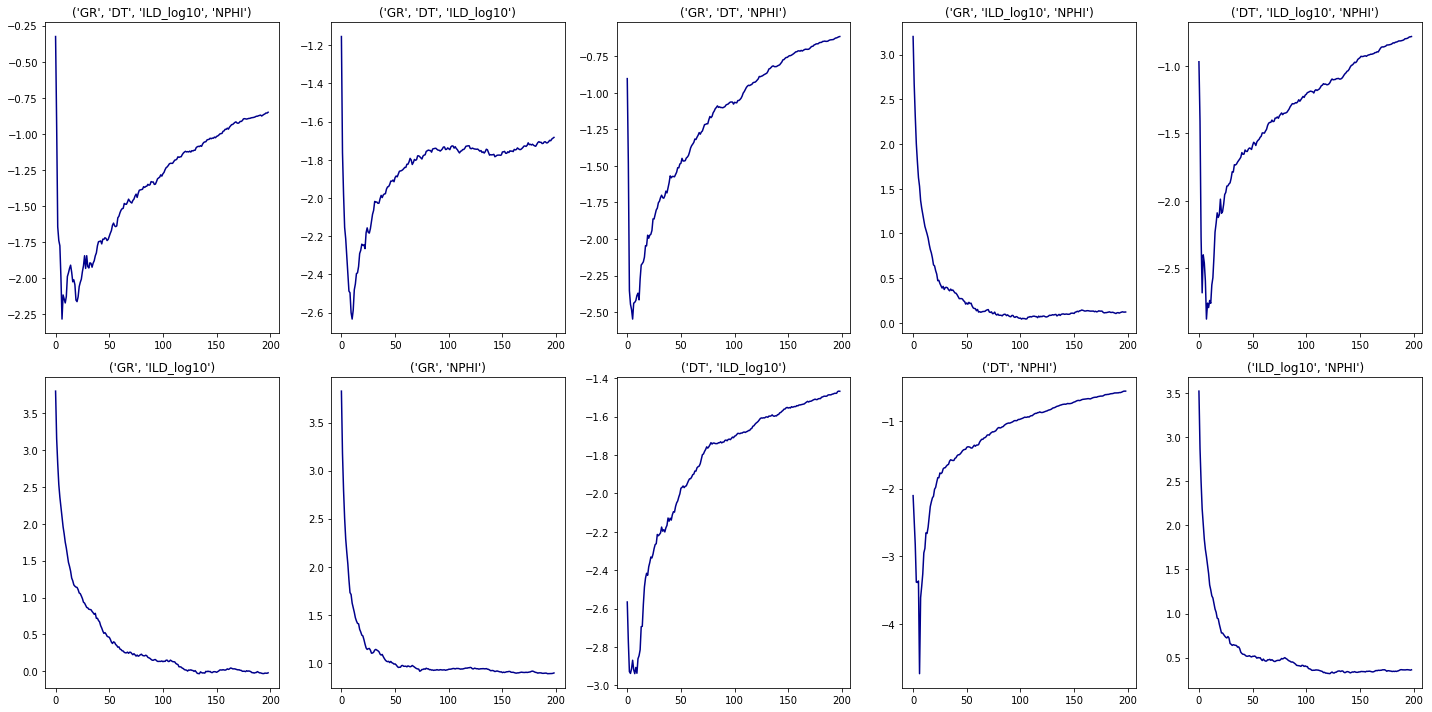

In [48]:
ncols=5
nrows=2
fig, axes = plt.subplots(ncols=5,nrows=2,figsize=(20,10))
i,j = 0,0
aux = 1
for i in range(nrows):
    for j in range(ncols):
        axes[i][j].plot(results_test.index,
                        np.log(np.asarray(results_test['{}'.format(aux)])-np.asarray(results_train['{}'.format(aux)])),
                        c='darkblue')
        axes[i][j].set_title('{}'.format(comb[aux-1]))
        aux+=1
    aux+=1
plt.tight_layout()

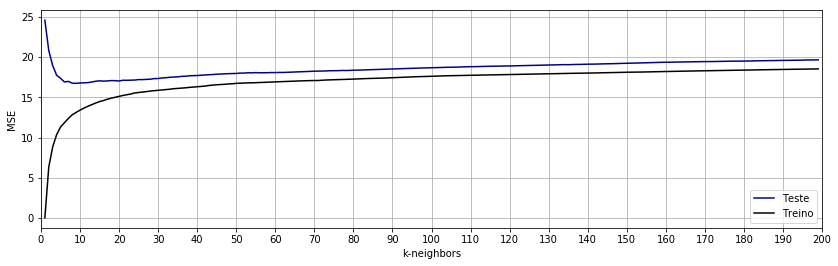

In [29]:
x = np.arange(1,len(results_test['1'])+1,1)

plt.figure(figsize=(14,4))
#plt.scatter(x,np.asarray(results_test['1']),edgecolor='black', c='darkblue', label='Teste')
plt.plot(x,np.asarray(results_test['4']), c='darkblue', label = 'Teste')

plt.plot(x,np.asarray(results_train['4']), c='black', label = 'Treino')
plt.ylabel('MSE')
plt.xlabel('k-neighbors')
plt.xlim((1,200))
#plt.title('GR-RHOB-log(ILD) MSE')
plt.grid()
#plt.yticks(np.arange(1,max(results_test['1']),.5))
plt.xticks(np.arange(0,200+1,10))
plt.legend(loc=4)
plt.savefig('mrse', format='png', dpi=300)

In [7]:
scaler = StandardScaler()
scaler.fit(dataset[['GR','ILD_log10','NPHI']])
x_blindscale = scaler.transform(blind_test[['GR','ILD_log10','NPHI']])

In [8]:
cv1 = KFold(n_splits=4, shuffle=True, random_state=42)

In [9]:
knn =  vizinho = KNeighborsRegressor()
params = {'n_neighbors':list(np.arange(1,201))}
nearest_neighbor = GridSearchCV(knn,params,scoring='neg_mean_squared_error', cv=cv1, return_train_score=True)
nearest_neighbor.fit(scaler.transform(dataset[['GR','ILD_log10','NPHI']]),dataset.RHOB)

GridSearchCV(cv=KFold(n_splits=4, random_state=42, shuffle=True),
             error_score='raise-deprecating',
             estimator=KNeighborsRegressor(algorithm='auto', leaf_size=30,
                                           metric='minkowski',
                                           metric_params=None, n_jobs=None,
                                           n_neighbors=5, p=2,
                                           weights='uniform'),
             iid='warn', n_jobs=None,
             param_grid={'n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12,
                                         13, 14, 15, 16, 17, 18, 19, 20, 21, 22,
                                         23, 24, 25, 26, 27, 28, 29, 30, ...]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
             scoring='neg_mean_squared_error', verbose=0)

In [10]:
print(nearest_neighbor.best_estimator_)
print(nearest_neighbor.best_params_)
print(nearest_neighbor.best_score_)

KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
                    metric_params=None, n_jobs=None, n_neighbors=14, p=2,
                    weights='uniform')
{'n_neighbors': 14}
-0.014992570800432458


In [11]:
df = pd.DataFrame(nearest_neighbor.cv_results_)

In [12]:
df.sort_values(by='rank_test_score')

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_n_neighbors,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,mean_train_score,std_train_score
13,0.006495,2.596580e-03,0.031483,0.004152,14,{'n_neighbors': 14},-0.014488,-0.016526,-0.014424,-0.014533,-0.014993,0.000886,1,-0.013166,-0.012591,-0.012881,-0.012979,-0.012904,0.000208
14,0.004997,7.067190e-04,0.027736,0.000828,15,{'n_neighbors': 15},-0.014529,-0.016581,-0.014370,-0.014530,-0.015003,0.000914,2,-0.013317,-0.012666,-0.013069,-0.013188,-0.013060,0.000244
12,0.008244,2.164494e-03,0.039478,0.005359,13,{'n_neighbors': 13},-0.014454,-0.016526,-0.014504,-0.014530,-0.015003,0.000879,3,-0.012990,-0.012415,-0.012720,-0.012840,-0.012741,0.000211
10,0.006245,8.300133e-04,0.026986,0.001580,11,{'n_neighbors': 11},-0.014486,-0.016638,-0.014428,-0.014510,-0.015015,0.000937,4,-0.012669,-0.012073,-0.012401,-0.012607,-0.012438,0.000232
15,0.005746,4.328442e-04,0.031483,0.003200,16,{'n_neighbors': 16},-0.014576,-0.016540,-0.014387,-0.014568,-0.015018,0.000882,5,-0.013432,-0.012818,-0.013222,-0.013259,-0.013183,0.000225
9,0.005496,1.117180e-03,0.025736,0.004262,10,{'n_neighbors': 10},-0.014628,-0.016539,-0.014493,-0.014465,-0.015031,0.000873,6,-0.012374,-0.011877,-0.012121,-0.012354,-0.012181,0.000202
11,0.005495,1.117874e-03,0.029238,0.001478,12,{'n_neighbors': 12},-0.014545,-0.016579,-0.014461,-0.014555,-0.015035,0.000892,7,-0.012853,-0.012242,-0.012570,-0.012769,-0.012609,0.000235
17,0.005995,1.414280e-03,0.031990,0.003006,18,{'n_neighbors': 18},-0.014585,-0.016681,-0.014391,-0.014525,-0.015045,0.000947,8,-0.013624,-0.013040,-0.013503,-0.013500,-0.013417,0.000223
16,0.006995,1.870279e-03,0.033731,0.002771,17,{'n_neighbors': 17},-0.014625,-0.016626,-0.014349,-0.014587,-0.015047,0.000918,9,-0.013538,-0.012958,-0.013341,-0.013361,-0.013300,0.000212
7,0.005997,2.451210e-03,0.023737,0.000829,8,{'n_neighbors': 8},-0.014638,-0.016663,-0.014432,-0.014473,-0.015052,0.000933,10,-0.011754,-0.011191,-0.011643,-0.011659,-0.011562,0.000218


In [13]:
y = np.log((-df.sort_values(by='param_n_neighbors').mean_test_score -
                            (-df.sort_values(by='param_n_neighbors').mean_train_score)))

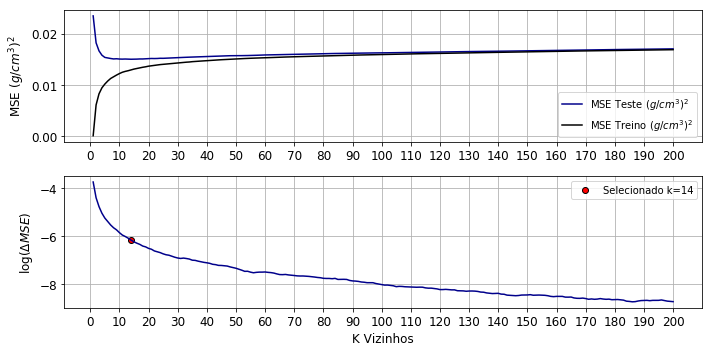

In [16]:
fig, axes = plt.subplots(2, figsize=(10,5))
axes[0].plot(df.sort_values(by='param_n_neighbors').param_n_neighbors, 
             (-(df.sort_values(by='param_n_neighbors')).mean_test_score), 
             c='darkblue', label='MSE Teste $(g/cm^3)^2$')
axes[0].plot(df.sort_values(by='param_n_neighbors').param_n_neighbors, 
             (-(df.sort_values(by='param_n_neighbors')).mean_train_score), 
             c='black', label='MSE Treino $(g/cm^3)^2$')
axes[0].set_ylabel('MSE $(g/cm^3)^2$')

axes[1].plot(df.sort_values(by='param_n_neighbors').param_n_neighbors, y, c='darkblue')
axes[1].set_xlabel('K Vizinhos')
axes[1].set_ylabel('log($\Delta MSE$)')

axes[1].scatter(df.sort_values(by='param_n_neighbors').param_n_neighbors[13],y[13], 
                c='red',edgecolor='black', label='Selecionado k=14')
for ax in axes:
    ax.legend()
    ax.grid()
    ax.set_xticks(np.arange(0,200+1,10))

plt.rc('xtick', labelsize=12)
plt.rc('ytick', labelsize=12)
plt.rc('axes', labelsize=12)

plt.tight_layout()

In [17]:
blind_test['RHOB_KNN'] = nearest_neighbor.predict(x_blindscale)

In [18]:
blind_test.head()

,DEPT,GR,ILD_log10,NPHI,RHOB,CAL,DT,perfil_id,Formacao,DT_Ridge,ILD,RHOB_Ridge,DT_KNN,RHOB_KNN
0,1968.0936,38.5907,0.486912,14.1915,2.4436,12.6899,72.6512,3MGP_0020,Candeias,74.929268,3.0684,2.417544,68.438229,2.347286
1,1968.2460,42.0137,0.495128,12.8958,2.4452,12.7673,72.1753,3MGP_0020,Candeias,74.272424,3.1270,2.447458,69.658694,2.361879
2,1968.3984,47.8897,0.503491,11.9561,2.4637,12.9126,72.0445,3MGP_0020,Candeias,73.710652,3.1878,2.484268,82.095318,2.395800
3,1968.5508,51.3829,0.516469,13.1344,2.4897,12.9163,71.5917,3MGP_0020,Candeias,74.006718,3.2845,2.487511,82.568606,2.441450
4,1968.7032,52.6227,0.530392,14.4057,2.5049,12.9239,71.4078,3MGP_0020,Candeias,74.374604,3.3915,2.479479,82.248765,2.406307


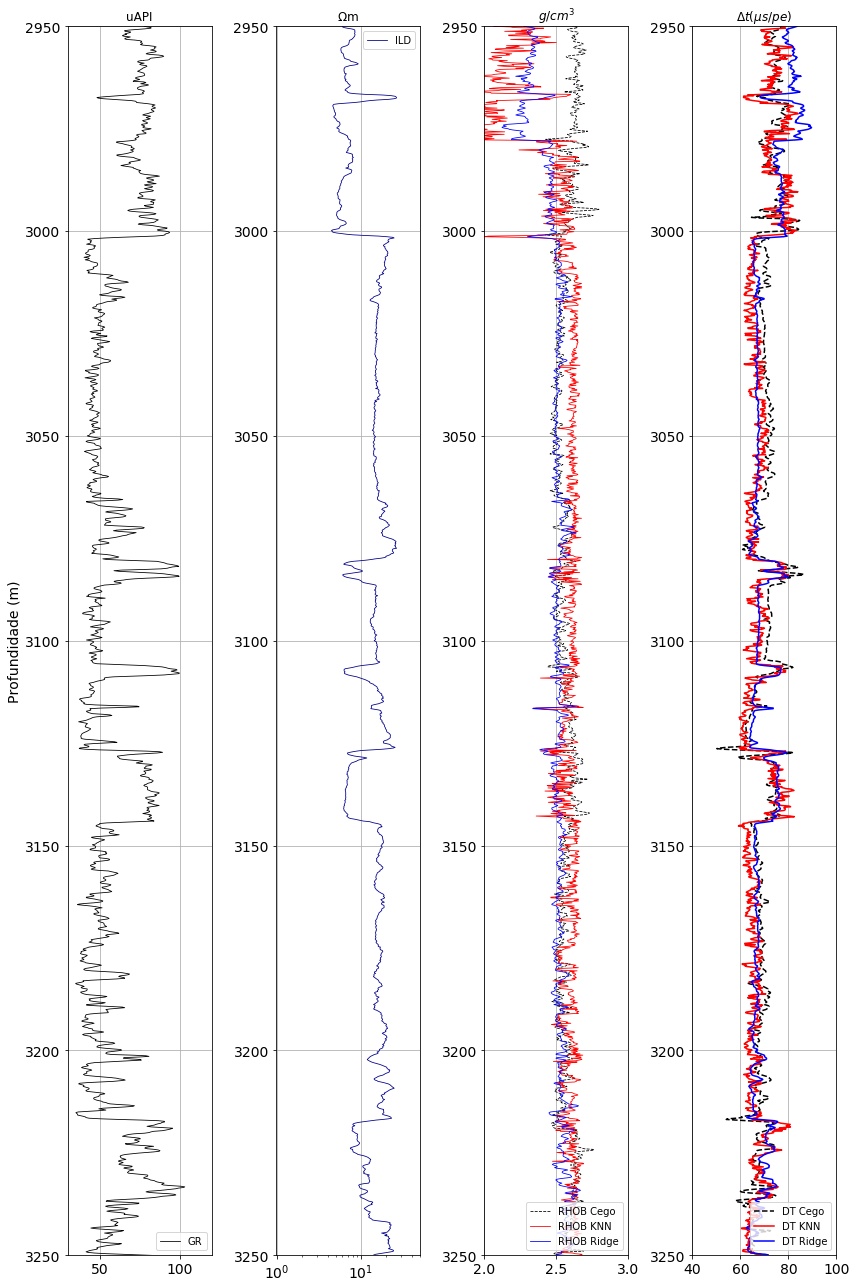

In [50]:
fig, axes = plt.subplots(ncols=4, figsize=(12,18))
#axes2 = axes[2].twiny()

axes[0].plot(blind_test.GR, blind_test.DEPT, c='black', label='GR', lw=0.8)
axes[0].set_xlim(30,120)

axes[1].semilogx(blind_test.ILD,blind_test.DEPT, c = 'darkblue', lw=0.8, label='ILD')
axes[1].set_xlim(0,50)

axes[2].plot(blind_test.RHOB, blind_test.DEPT, c = 'black', label='RHOB Cego', lw = 0.8, ls='--')
axes[2].plot(blind_test.RHOB_KNN,blind_test.DEPT, c='red', label='RHOB KNN', lw=0.8)
axes[2].plot(blind_test.RHOB_Ridge, blind_test.DEPT, c='blue', label='RHOB Ridge', lw=0.8)
axes[2].set_xlim(2,3)

# axes2.plot(blind_test.NPHI, blind_test.DEPT, c = 'blue', label = 'NPHI', lw = 0.8, ls='--')
# axes2.set_xlim(0,45)
# axes2.legend(loc='upper right')
# axes2.invert_yaxis()

axes[3].plot(blind_test.DT.loc[(blind_test.DT > 0)].values, 
           blind_test.DEPT.loc[(blind_test.DT > 0)].values, c='black', label='DT Cego', ls='--')
axes[3].plot(blind_test.DT_KNN.loc[(blind_test.GR > 0) & (blind_test.ILD > 0) & (blind_test.RHOB > 0) & (blind_test.CAL > 0)].values, 
             blind_test.DEPT.loc[(blind_test.GR > 0) & (blind_test.ILD > 0) & (blind_test.RHOB > 0) & (blind_test.CAL > 0)].values,
             c='red', label='DT KNN')
axes[3].plot(blind_test.DT_Ridge.loc[(blind_test.GR > 0) & (blind_test.ILD > 0) & (blind_test.RHOB > 0) & (blind_test.CAL > 0)].values, 
             blind_test.DEPT.loc[(blind_test.GR > 0) & (blind_test.ILD > 0) & (blind_test.RHOB > 0) & (blind_test.CAL > 0)].values,
             c='blue', label='DT Ridge')
axes[3].set_xlim(40,100)

axes[0].set_title('uAPI')
axes[1].set_title('$\Omega$m')
axes2.set_xlabel('$\phi_n$(%)')
axes[2].set_title('$g/cm^3$')
axes[3].set_title('$\Delta t  (\mu s/pe )$')
axes[0].set_ylabel('Profundidade (m)')


for ax in axes:
    ax.set_ylim(2950,3250)
    ax.invert_yaxis()
    ax.grid()
    ax.legend()
    
axes[2].legend(loc='lower right')
axes[3].legend(loc='lower right')

plt.rc('xtick', labelsize=14)
plt.rc('ytick', labelsize=14)
plt.rc('axes', labelsize=14)

fig.tight_layout()

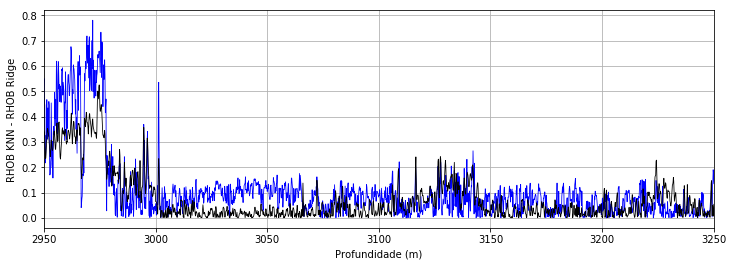

In [65]:
plt.figure(figsize=(12,4))
plt.plot(blind_test.DEPT,abs(blind_test.RHOB - blind_test.RHOB_KNN), lw=0.8, c='blue')
plt.plot(blind_test.DEPT,abs(blind_test.RHOB - blind_test.RHOB_Ridge), lw=0.8, c='black')
plt.xlim(2950,3250)
plt.xlabel('Profundidade (m)')
plt.ylabel('RHOB KNN - RHOB Ridge')
plt.xticks(np.arange(2950,3250+1,50))
plt.grid()

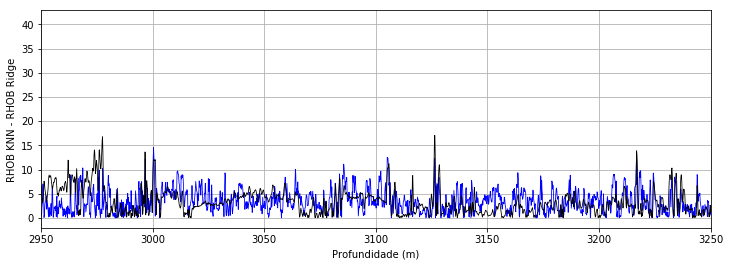

In [66]:
plt.figure(figsize=(12,4))
plt.plot(blind_test.DEPT,abs(blind_test.DT - blind_test.DT_KNN), lw=0.8, c='blue')
plt.plot(blind_test.DEPT,abs(blind_test.DT - blind_test.DT_Ridge), lw=0.8, c='black')
plt.xlim(2950,3250)
plt.xlabel('Profundidade (m)')
plt.ylabel('RHOB KNN - RHOB Ridge')
plt.xticks(np.arange(2950,3250+1,50))
plt.grid()

In [67]:
blind_test.to_csv(r'C:/Users/mathe/Desktop/MATHEUS/UFBA/IC/shalegas-rad/blind_data.csv')

### DT

In [38]:
np.sqrt(mean_squared_error(blind_test[blind_test.GR > 75].DT_Ridge, blind_test[blind_test.GR > 75].DT))

7.149521055122267

In [39]:
np.sqrt(mean_squared_error(blind_test[blind_test.GR > 75].DT_KNN, blind_test[blind_test.GR > 75].DT))

5.109115215628155

In [40]:
np.sqrt(mean_squared_error(blind_test[blind_test.GR < 75].DT_Ridge, blind_test[blind_test.GR < 75].DT))

4.861685001255265

In [41]:
np.sqrt(mean_squared_error(blind_test[blind_test.GR < 75].DT_KNN, blind_test[blind_test.GR < 75].DT))

5.634665149045245

### RHOB

In [42]:
np.sqrt(mean_squared_error(blind_test[blind_test.GR > 75].RHOB_Ridge, blind_test[blind_test.GR > 75].RHOB))

0.15957527925790707

In [43]:
np.sqrt(mean_squared_error(blind_test[blind_test.GR > 75].RHOB_KNN, blind_test[blind_test.GR > 75].RHOB))

0.2119271995673982

In [44]:
np.sqrt(mean_squared_error(blind_test[blind_test.GR < 75].RHOB_Ridge, blind_test[blind_test.GR < 75].RHOB))

0.1052311601054082

In [45]:
np.sqrt(mean_squared_error(blind_test[blind_test.GR < 75].RHOB_KNN, blind_test[blind_test.GR < 75].RHOB))

0.15149868394530008